In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pathlib import Path

---
# Load files and Functions

## Load files and EDA

In [2]:
#read bridges and info about LRP data
lrp = pd.read_csv('../data/raw/Roads_InfoAboutEachLRP.csv', low_memory=False)
df_bridge = pd.read_excel("../data/raw/BMMS_overview.xlsx")
road = pd.read_csv('../data/raw/_roads.tsv', sep='\t', low_memory=False)

## Duplicate values function

In [3]:
def check_duplicates(df, cols=None, excl=None):
    """
    Flags duplicate rows and returns dataframe + log dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
    cols : list or None
        Columns to check subset duplicates on (optional)
    excl : list or None
        Columns to ignore during duplicate checking

    Returns
    -------
    df_out : dataframe with 'duplicate' column
    log_df : dataframe containing duplicated rows with reason
    """

    df_out = df.copy()
    #df_out["duplicate"] = False

    log_parts = []

    # columns to exclude
    excl = excl or []

    # ---------- 1) FULL ROW DUPLICATES ----------
    full_cols = [c for c in df_out.columns if c not in excl]

    dup_full_mask = df_out.duplicated(subset=full_cols, keep=False)
    #df_out.loc[dup_full_mask, "duplicate"] = True

    if dup_full_mask.any():
        log_full = df_out.loc[dup_full_mask].copy()
        log_full["duplicate_reason"] = f"all column duplicate"
        log_parts.append(log_full)
    df_out=df_out.drop_duplicates(subset=full_cols)

    # ---------- 2) SUBSET DUPLICATES ----------
    if cols:
        subset_cols = [c for c in cols if c not in excl]

        if len(subset_cols) > 0:
            dup_subset_mask = df_out.duplicated(subset=subset_cols, keep=False)
            #df_out.loc[dup_subset_mask, "duplicate"] = True

            if dup_subset_mask.any():
                log_subset = df_out.loc[dup_subset_mask].copy()
                log_subset["duplicate_reason"] = f"duplicate on:{subset_cols}"
                log_parts.append(log_subset)
        df_out=df_out.drop_duplicates(subset=subset_cols)

    # ---------- COMBINE LOG ----------
    if log_parts:
        log_df = pd.concat(log_parts).drop_duplicates().reset_index(drop=True)
    else:
        log_df = pd.DataFrame(columns=list(df_out.columns) + ["duplicate_reason"])

    return df_out, log_df

## Fixing roads and bridges function

In [4]:
import re

_lrp_re = re.compile(r"^LRP(\d+)([A-Za-z]*)$")

def lrp_sort_key(lrp: str):
    """
    Returns a tuple used for sorting LRPs in chainage-like order:
    LRPS, LRPSa, LRPSb ... first
    then LRP001, LRP001a, LRP001b ...
    then ...
    LRPE last
    Unknown formats go to the end (but before LRPE).
    """
    if pd.isna(lrp):
        return (10**9, "zz")  # push NA to end
    
    s = str(lrp).strip()

    # Start markers
    if s == "LRPS":
        return (-1, "")
    if s.startswith("LRPS") and len(s) > 4:
        # LRPSa, LRPSb ...
        return (-1, s[4:])

    # End marker
    if s == "LRPE":
        return (10**12, "zzzz")

    # Standard LRP###suffix
    m = _lrp_re.match(s)
    if m:
        num = int(m.group(1))
        suf = m.group(2) or ""
        return (num, suf)

    # fallback for weird labels
    return (10**9, s)

def sort_road_by_lrp(df_points):
    df = df_points.copy()
    df["_k"] = df["lrp"].apply(lrp_sort_key)
    df = df.sort_values("_k").drop(columns="_k").reset_index(drop=True)
    return df


In [5]:
# ----------------------------
# Distance
# ----------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def compute_segments(df):
    """Adds next_lat/next_lon + seg distance. Expects ordered points."""
    out = df.copy()
    out["next_lat"] = out["lat"].shift(-1)
    out["next_lon"] = out["lon"].shift(-1)
    out["seg"] = haversine(out["lat"], out["lon"], out["next_lat"], out["next_lon"])
    return out

# ----------------------------
# Stage A: Block repair
# ----------------------------
def block_repair(df_points, K=15, min_run_len=2):
    """
    Detect consecutive jump segments and linearly interpolate across the block.
    df_points: columns ['lrp','lat','lon'] in correct order.
    Returns: fixed_df, actions(list)
    """
    df = compute_segments(df_points).reset_index(drop=True)
    median_seg = df["seg"].median()
    thr = K * median_seg

    df["is_jump_seg"] = df["seg"] > thr
    df["run_id"] = (df["is_jump_seg"] != df["is_jump_seg"].shift()).cumsum()

    jump_runs = df[df["is_jump_seg"]].groupby("run_id").indices
    fixed = df_points.copy().reset_index(drop=True)
    actions = []

    for run_id, idxs in jump_runs.items():
        idxs = list(idxs)
        if len(idxs) < min_run_len:
            continue

        # segments idxs[0]..idxs[-1] correspond to points [left_idx .. right_idx]
        left_idx = idxs[0]
        right_idx = idxs[-1] + 1

        # bounds + must have endpoints
        if left_idx <= 0 or right_idx >= len(fixed):
            continue
        if fixed.loc[left_idx, ["lat","lon"]].isna().any() or fixed.loc[right_idx, ["lat","lon"]].isna().any():
            continue

        L = right_idx - left_idx
        for k in range(1, L):
            new_lat = fixed.loc[left_idx, "lat"] + (fixed.loc[right_idx, "lat"] - fixed.loc[left_idx, "lat"]) * (k / L)
            new_lon = fixed.loc[left_idx, "lon"] + (fixed.loc[right_idx, "lon"] - fixed.loc[left_idx, "lon"]) * (k / L)

            old_lat, old_lon = fixed.loc[left_idx+k, "lat"], fixed.loc[left_idx+k, "lon"]
            fixed.loc[left_idx+k, "lat"] = new_lat
            fixed.loc[left_idx+k, "lon"] = new_lon

            actions.append({
                "idx": left_idx+k,
                "lrp": fixed.loc[left_idx+k, "lrp"],
                "action": "block_interp",
                "old_lat": old_lat, "old_lon": old_lon,
                "new_lat": new_lat, "new_lon": new_lon,
                "run_len": len(idxs),
                "thr_km": thr
            })

    return fixed, actions

# ----------------------------
# Stage B: Smart single-segment repair
# ----------------------------
def smart_single_seg_repair(df_points, K=15, max_iters=5):
    """
    Fix remaining isolated jump segments by deciding whether to adjust point i or i+1.
    df_points: columns ['lrp','lat','lon'] ordered.
    Returns: fixed_df, actions(list)
    """
    df = df_points.copy().reset_index(drop=True)
    actions = []

    for _ in range(max_iters):
        tmp = compute_segments(df)
        med = tmp["seg"].median()
        thr = K * med

        bad_idxs = tmp.index[tmp["seg"] > thr].tolist()
        if not bad_idxs:
            break

        for i in bad_idxs:
            # need neighborhood i-1, i, i+1, i+2
            if i <= 0 or i >= len(df)-2:
                continue

            p_im1 = (df.loc[i-1, "lat"], df.loc[i-1, "lon"])
            p_i   = (df.loc[i,   "lat"], df.loc[i,   "lon"])
            p_ip1 = (df.loc[i+1, "lat"], df.loc[i+1, "lon"])
            p_ip2 = (df.loc[i+2, "lat"], df.loc[i+2, "lon"])

            if any(pd.isna([*p_im1, *p_i, *p_ip1, *p_ip2])):
                continue

            cur = (
                haversine(p_im1[0], p_im1[1], p_i[0], p_i[1]) +
                haversine(p_i[0], p_i[1], p_ip1[0], p_ip1[1]) +
                haversine(p_ip1[0], p_ip1[1], p_ip2[0], p_ip2[1])
            )

            # Fix A: adjust point i
            fixA = ((p_im1[0] + p_ip1[0]) / 2, (p_im1[1] + p_ip1[1]) / 2)
            scoreA = (
                haversine(p_im1[0], p_im1[1], fixA[0], fixA[1]) +
                haversine(fixA[0], fixA[1], p_ip1[0], p_ip1[1]) +
                haversine(p_ip1[0], p_ip1[1], p_ip2[0], p_ip2[1])
            )

            # Fix B: adjust point i+1
            fixB = ((p_i[0] + p_ip2[0]) / 2, (p_i[1] + p_ip2[1]) / 2)
            scoreB = (
                haversine(p_im1[0], p_im1[1], p_i[0], p_i[1]) +
                haversine(p_i[0], p_i[1], fixB[0], fixB[1]) +
                haversine(fixB[0], fixB[1], p_ip2[0], p_ip2[1])
            )

            best = min(cur, scoreA, scoreB)
            if best >= cur:
                continue

            if best == scoreA:
                old_lat, old_lon = df.loc[i, "lat"], df.loc[i, "lon"]
                df.loc[i, "lat"], df.loc[i, "lon"] = fixA
                actions.append({
                    "idx": i,
                    "lrp": df.loc[i, "lrp"],
                    "action": "smart_fix_i_mid(im1,ip1)",
                    "old_lat": old_lat, "old_lon": old_lon,
                    "new_lat": fixA[0], "new_lon": fixA[1],
                    "thr_km": thr
                })
            else:
                old_lat, old_lon = df.loc[i+1, "lat"], df.loc[i+1, "lon"]
                df.loc[i+1, "lat"], df.loc[i+1, "lon"] = fixB
                actions.append({
                    "idx": i+1,
                    "lrp": df.loc[i+1, "lrp"],
                    "action": "smart_fix_i+1_mid(i,ip2)",
                    "old_lat": old_lat, "old_lon": old_lon,
                    "new_lat": fixB[0], "new_lon": fixB[1],
                    "thr_km": thr
                })

    return df, actions

def end_point_anomaly_repair(df_points, K=15, max_iters=2):
    """
    Fix LRPE (last point) anomalies if the last segment is a jump.
    Only adjusts the last point using simple extrapolation from the previous two points.
    df_points: columns ['lrp','lat','lon'] ordered.
    Returns: fixed_df, actions(list)
    """
    df = df_points.copy().reset_index(drop=True)
    actions = []

    for _ in range(max_iters):
        tmp = compute_segments(df)
        med = tmp["seg"].median()
        if pd.isna(med) or med == 0 or len(df) < 3:
            break

        thr = K * med
        last_seg = tmp.loc[len(df) - 2, "seg"]  # segment (n-2)->(n-1)

        # no issue
        if pd.isna(last_seg) or last_seg <= thr:
            break

        # need last 3 points: n-3, n-2, n-1
        n = len(df)
        p_nm3 = (df.loc[n-3, "lat"], df.loc[n-3, "lon"])
        p_nm2 = (df.loc[n-2, "lat"], df.loc[n-2, "lon"])
        p_nm1 = (df.loc[n-1, "lat"], df.loc[n-1, "lon"])

        if any(pd.isna([*p_nm3, *p_nm2, *p_nm1])):
            break

        # Extrapolate last point along direction (n-3)->(n-2)
        new_lat = p_nm2[0] + (p_nm2[0] - p_nm3[0])
        new_lon = p_nm2[1] + (p_nm2[1] - p_nm3[1])

        old_lat, old_lon = df.loc[n-1, "lat"], df.loc[n-1, "lon"]
        df.loc[n-1, "lat"], df.loc[n-1, "lon"] = new_lat, new_lon

        actions.append({
            "idx": n-1,
            "lrp": df.loc[n-1, "lrp"],
            "action": "end_extrap_lrpe",
            "old_lat": old_lat, "old_lon": old_lon,
            "new_lat": new_lat, "new_lon": new_lon,
            "thr_km": thr,
            "last_seg_km": float(last_seg),
        })

    return df, actions

# ----------------------------
# Full repair for one road
# ----------------------------
def repair_road_points(df_road_points, K=15, min_run_len=2):
    df_road_points = sort_road_by_lrp(df_road_points)

    before = compute_segments(df_road_points)
    before_med = before["seg"].median()
    before_thr = K * before_med
    before_jumps = int((before["seg"] > before_thr).sum())
    before_max = float(before["seg"].max())

    fixedA, actionsA = block_repair(df_road_points, K=K, min_run_len=min_run_len)
    fixedB, actionsB = smart_single_seg_repair(fixedA, K=K)

    fixedC, actionsC = end_point_anomaly_repair(fixedB, K=K)

    after = compute_segments(fixedC)
    after_med = after["seg"].median()
    after_thr = K * after_med
    after_jumps = int((after["seg"] > after_thr).sum())
    after_max = float(after["seg"].max())

    metrics = {
        "median_seg_before": before_med,
        "thr_before": before_thr,
        "jumps_before": before_jumps,
        "max_seg_before": before_max,
        "median_seg_after": after_med,
        "thr_after": after_thr,
        "jumps_after": after_jumps,
        "max_seg_after": after_max,
        "actions_block": len(actionsA),
        "actions_smart": len(actionsB),
        "actions_end": len(actionsC),
        "actions_total": len(actionsA) + len(actionsB) + len(actionsC),
    }

    actions = actionsA + actionsB + actionsC
    return fixedC, actions, metrics

# ----------------------------
# Plot before/after for a road
# ----------------------------
def plot_road_before_after(tidy_df, road_name, fixed_df=None, K=15, title_suffix=""):
    """
    tidy_df: full tidy dataframe (road, lrp, lat, lon) in original order
    fixed_df: optional fixed points (lrp, lat, lon) for the road; if None we repair on the fly.
    """
    road_pts = tidy_df[tidy_df["road"] == road_name][["lrp","lat","lon"]].copy().reset_index(drop=True)

    if fixed_df is None:
        fixed_df, _, metrics = repair_road_points(road_pts, K=K)
    else:
        metrics = None

    # plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].plot(road_pts["lon"], road_pts["lat"], marker="o", markersize=2, linewidth=1)
    axes[0].set_title(f"{road_name} BEFORE {title_suffix}")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    axes[1].plot(fixed_df["lon"], fixed_df["lat"], marker="o", markersize=2, linewidth=1)
    axes[1].set_title(f"{road_name} AFTER {title_suffix}")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()

    if metrics is not None:
        print(metrics)

# ----------------------------
# Repair ALL roads
# ----------------------------
def repair_all_roads(tidy_df, K=15, min_run_len=2, max_roads=None):
    """
    tidy_df: columns ['road','lrp','lat','lon'] in original order
    Returns: cleaned_tidy_df, actions_df, metrics_df
    """
    cleaned_parts = []
    all_actions = []
    all_metrics = []

    roads = tidy_df["road"].dropna().unique().tolist()
    if max_roads is not None:
        roads = roads[:max_roads]

    for r in roads:
        road_pts = tidy_df[tidy_df["road"] == r][["lrp","lat","lon"]].copy().reset_index(drop=True)
        fixed_pts, actions, metrics = repair_road_points(road_pts, K=K, min_run_len=min_run_len)

        fixed_out = fixed_pts.copy()
        fixed_out.insert(0, "road", r)
        cleaned_parts.append(fixed_out)

        for a in actions:
            a["road"] = r
        all_actions.extend(actions)

        metrics["road"] = r
        all_metrics.append(metrics)

    cleaned = pd.concat(cleaned_parts, ignore_index=True)
    actions_df = pd.DataFrame(all_actions)
    metrics_df = pd.DataFrame(all_metrics)

    return cleaned, actions_df, metrics_df


In [6]:
def plot_three_all_roads_lines(before_df, after_df, ref_df):
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))

    datasets = [
        (before_df, "(a) Raw Data"),
        (after_df, "(b) Our Cleaned Data"),
        (ref_df, "(c) Reference Data (_roads3.csv)")
    ]

    for ax, (df, title) in zip(axes, datasets):
        for road, group in df.groupby("road"):
            ax.plot(
                group["lon"],
                group["lat"],
                linewidth=0.5,
                color="blue"
            )

        ax.set_title(title)
        ax.set_xlabel("Longitude")

    # Only left subplot keeps y-label (cleaner for report)
    axes[0].set_ylabel("Latitude")
    axes[1].set_ylabel("")
    axes[2].set_ylabel("")

    fig.suptitle("Road Network Geometry", fontsize=16)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_road_raw_clean_ref(
    raw_tidy, cleaned_tidy, road_name,
    ref_tidy=None, show_ref=True,
    title_suffix="", figsize=(20, 6),
    marker="o", markersize=2, linewidth=1
):
    """
    raw_tidy: tidy df (road, lrp, lat, lon) - BEFORE
    cleaned_tidy: tidy df (road, lrp, lat, lon) - AFTER (already cleaned; no repair here)
    ref_tidy: tidy df (road, lrp, lat, lon) - REFERENCE (optional)
    """

    # BEFORE
    road_pts = (
        raw_tidy[raw_tidy["road"] == road_name][["lrp", "lat", "lon"]]
        .copy()
        .reset_index(drop=True)
    )
    if road_pts.empty:
        print(f"Road {road_name} not found in raw_tidy.")
        return

    # AFTER (already cleaned)
    cleaned_pts = (
        cleaned_tidy[cleaned_tidy["road"] == road_name][["lrp", "lat", "lon"]]
        .copy()
        .reset_index(drop=True)
    )
    if cleaned_pts.empty:
        print(f"Road {road_name} not found in cleaned_tidy.")
        return

    # REFERENCE (optional)
    prof_pts = None
    if show_ref and ref_tidy is not None:
        prof_pts = (
            ref_tidy[ref_tidy["road"] == road_name][["lrp", "lat", "lon"]]
            .copy()
            .reset_index(drop=True)
        )

    # Panels (preserve your original layout)
    ncols = 3 if (show_ref and ref_tidy is not None) else 2
    fig, axes = plt.subplots(1, ncols, figsize=figsize)

    # (a) BEFORE
    axes[0].plot(road_pts["lon"], road_pts["lat"],
                 marker=marker, markersize=markersize, linewidth=linewidth, color="blue")
    axes[0].set_title("(a) Raw Data")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    # (b) AFTER
    axes[1].plot(cleaned_pts["lon"], cleaned_pts["lat"],
                 marker=marker, markersize=markersize, linewidth=linewidth, color="blue")
    axes[1].set_title("(b) Our Cleaned Data")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    # (c) REFERENCE
    if ncols == 3:
        if prof_pts is None or prof_pts.empty:
            axes[2].text(0.5, 0.5, "Road not in reference data",
                         ha="center", va="center")
            axes[2].set_axis_off()
        else:
            axes[2].plot(prof_pts["lon"], prof_pts["lat"],
                         marker=marker, markersize=markersize, linewidth=linewidth, color="blue")
            axes[2].set_title("(c) Reference Data (_roads3.csv)")
            axes[2].set_xlabel("Longitude")
            axes[2].set_ylabel("Latitude")
    fig.suptitle(f"Road {road_name}", fontsize=14)

    plt.tight_layout()
    plt.show()

In [8]:
def repair_all_bridges(tidy_df, K=15, min_run_len=2, max_roads=None):
    """
    tidy_df: columns ['road','lrp','lat','lon'] in original order
    Returns: cleaned_tidy_df, actions_df, metrics_df
    """
    cleaned_parts = []
    all_actions = []
    all_metrics = []

    roads = tidy_df["road"].dropna().unique().tolist()
    if max_roads is not None:
        roads = roads[:max_roads]

    for r in roads:
        road_pts = tidy_df[tidy_df["road"] == r].copy().reset_index(drop=True)
        fixed_pts, actions, metrics = repair_road_points(road_pts, K=K, min_run_len=min_run_len)

        fixed_out = fixed_pts.copy()
        #fixed_out.insert(0, "road", r)
        cleaned_parts.append(fixed_out)

        for a in actions:
            a["road"] = r
        all_actions.extend(actions)

        metrics["road"] = r
        all_metrics.append(metrics)

    cleaned = pd.concat(cleaned_parts, ignore_index=True)
    actions_df = pd.DataFrame(all_actions)
    metrics_df = pd.DataFrame(all_metrics)

    return cleaned, actions_df, metrics_df

In [9]:
def plot_all_bridge_before_after(tidy_df, cleaned_df):
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # BEFORE
    axes[0].scatter(
        tidy_df["lon"], tidy_df["lat"],
        s=1, alpha=0.5
    )
    axes[0].set_title("All bridges in roads BEFORE Repair")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    # AFTER
    axes[1].scatter(
        cleaned_df["lon"], cleaned_df["lat"],
        s=1, alpha=0.5
    )
    axes[1].set_title("All bridges in roads AFTER Repair")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()


## Chainage monotony function

In [10]:
#Function to check monotony in datasets

def check_chainage_monotony(df):
    # convert the chainage column to numeric values, if value cannot be converted it becomes NaN
    df["chainage"] = pd.to_numeric(df["chainage"], errors="coerce")
    # create empty list to store True or False values indicating whether there's monotony within each road group
    report = []
    # loop through each group of rows grouped by "road"
    for road, group in df.groupby("road"):
        # reset index inside each group so iteration start from 0 (and drop old index column)
        group = group.reset_index(drop=True)
        # variable to keep track of previous chainage value
        prev_chainage = None
        # iterate through each row in the grouped DataFrame
        for i, row in group.iterrows():
            current_chainage = row["chainage"]

            # it it's the first row in the group, it will automatically be marked as monotone (True)
            if prev_chainage is None:
                report.append(True)
            else:
                # Check if current chainage is greater than or equal to the previous one
                report.append(current_chainage >= prev_chainage)
            # update chainage for next iteration
            prev_chainage = current_chainage

    # add the report as new column to original dataframe
    df["monotone"] = report

    not_monotone = df.groupby("road")["monotone"].all().eq(False).sum()
    # print results
    if not_monotone == 0:
        print("All roads in the dataset have chainage monotony")
    else:
        print(not_monotone, "roads break chainage monotony")
        road_monotone = df.groupby("road")["monotone"].all()
        broken_roads = road_monotone[road_monotone ==False].index
        print("Roads that break monotony:", broken_roads)

In [11]:
# Observing the dataset, the roads seem to be all over the place
# N1 in initial rows but also afterwards
# Here's a function to group and sort them in order

def fix_chainage_monotony(df): 
    df = df.copy()
    # group frist by road and sort each road by chainage
    df_sorted = df.sort_values(by=["road", "chainage"]).reset_index(drop=True)
    return df_sorted

In [12]:
# Checking that roads in the roads data set also exist on the bridge dataset

import pandas as pd


def check_bridges_invalid_roads(roads_df, bridges_df):
    """
    Returns a boolean Series indicating if each bridge is on a road in roads_df.

    Parameters:
    - roads_df: DataFrame with a road column
    - bridges_df: DataFrame with a road column

    Returns:
    - pd.Series of bool, True if bridge is on a valid road
    """
    valid_roads = set(roads_df["road"])
    invalid_mask = ~bridges_df["road"].isin(valid_roads)
    return bridges_df[invalid_mask]

In [13]:
# Dropping of roads in bridges that aren't in the roads dataset


def drop_invalid_bridges(roads_df, bridges_df):
    """
    Removes bridges whose road is NOT in roads_df (in-place).

    Parameters:
    - roads_df: DataFrame with valid roads
    - bridges_df: DataFrame with bridges to filter

    Returns:
    cleaned dataframe
    """
    mask = check_bridges_invalid_roads(roads_df, bridges_df)
    list_of_invalid_bridges = mask["road"].unique()
    df_filtered = bridges_df[~bridges_df["road"].isin(list_of_invalid_bridges)].copy()
    return df_filtered

## Inverted lon lat function

In [14]:
min_lat, max_lat = 20.74, 26.64
min_lon, max_lon = 88.00, 92.68

def detect_bridges_inverted_coordinates(df1, lat_col='lat', lon_col='lon', road_col='road', lrp_col='LRPName'):
    df=df1.copy()
    # Create flags for inverted coordinates and far-out coordinates
    df['inverted_coords'] = (
        (df[lat_col] >= min_lon) & (df[lat_col] <= max_lon) &  # Latitude in longitude range
        (df[lon_col] >= min_lat) & (df[lon_col] <= max_lat)    # Longitude in latitude range
    )
    
    return df

In [15]:
def swap_lat_lon(df1):
    """
    Swap lat/lon only where inverted_coords == True
    and set the flag to False after correction

    Returns:
        corrected dataframe
        log dataframe
    """

    df = df1.copy()

    mask = df["inverted_coords"] == True

    # ---- CREATE LOG BEFORE CHANGING ----
    log_df = pd.DataFrame({
        "road": df.loc[mask, "road"],
        "LRPName": df.loc[mask, "LRPName"],
        "old_lat": df.loc[mask, "lat"],
        "old_lon": df.loc[mask, "lon"],
        "new_lat": df.loc[mask, "lon"],
        "new_lon": df.loc[mask, "lat"],
    }).reset_index(drop=True)

    # ---- SWAP COORDINATES ----
    df.loc[mask, ["lat", "lon"]] = df.loc[mask, ["lon", "lat"]].values

    # ---- TURN OFF FLAG ----
    df.loc[mask, "inverted_coords"] = False

    return df, log_df

## Out of boundary box function

In [16]:
def detect_bridges_out_coordinates(df1, lat_col='lat', lon_col='lon', road_col='road', lrp_col='LRPName'):
    df=df1.copy()
        
    df['far_out_coords'] = ( 
        ((df[lat_col] < min_lat) | (df[lat_col] > max_lat)) &  # Latitude outside range
        ((df[lon_col] < min_lon) | (df[lon_col] > max_lon))    # Longitude outside range
    )
    
    return df

In [17]:
def fix_far_out_coords(b, lrp):
    """
    Correct coordinates in dataframe b using reference dataframe lrp.
    Only rows with far_out_coords == True are processed.

    Returns:
        corrected dataframe
        log dataframe of applied changes
    """

    b = b.copy()

    # rows to process
    mask = b["far_out_coords"] == True
    b_sub = b.loc[mask]

    # merge subset with reference
    merged = b_sub.merge(
        lrp[["road", "lrp", "lat", "lon"]],
        left_on=["road", "LRPName"],
        right_on=["road", "lrp"],
        how="left",
        suffixes=("", "_ref")
    )

    # rows where match exists
    matched = merged["lat_ref"].notna()

    # --- CREATE LOG ---
    log_df = pd.DataFrame({
        "road": merged.loc[matched, "road"],
        "LRPName": merged.loc[matched, "LRPName"],
        "old_lat": merged.loc[matched, "lat"],
        "old_lon": merged.loc[matched, "lon"],
        "new_lat": merged.loc[matched, "lat_ref"],
        "new_lon": merged.loc[matched, "lon_ref"],
    }).reset_index(drop=True)

    # --- UPDATE ORIGINAL DATAFRAME ---
    idx_to_update = b_sub.index[matched]

    b.loc[idx_to_update, "lat"] = merged.loc[matched, "lat_ref"].values
    b.loc[idx_to_update, "lon"] = merged.loc[matched, "lon_ref"].values
    b.loc[idx_to_update, "far_out_coords"] = False

    return b, log_df

## NaN Values lookup function

In [18]:
def drop_redundant_nan_coords(df):
    """
    Remove rows with NaN lat/lon only when a valid coordinate exists
    for the same (road, LRPName).

    Returns:
        cleaned dataframe
        removed rows log
    """

    df = df.copy()

    # rows with missing coords
    nan_mask = df["lat"].isna() | df["lon"].isna()
    df_nan = df[nan_mask].copy()

    # keep original index
    df_nan["_orig_index"] = df_nan.index

    # rows with valid coords
    df_valid_keys = df.loc[~nan_mask, ["road", "LRPName"]].drop_duplicates()

    # find NaN rows that have a valid twin
    matched = df_nan.merge(df_valid_keys, on=["road", "LRPName"], how="inner")

    drop_idx = matched["_orig_index"]

    # log removed rows
    removed_log = df.loc[drop_idx].copy()

    # drop only those rows
    df_cleaned = df.drop(index=drop_idx)

    return df_cleaned.reset_index(drop=True), removed_log.reset_index(drop=True)

In [19]:
def fill_nan_coords(df, lrp):
    """
    Fill missing lat/lon in df using reference dataframe lrp.

    Conditions:
    - Only rows where lat OR lon is NaN are processed
    - Match on df.road == lrp.road AND df.LRPName == lrp.lrp
    - Only update when match exists
    - Returns corrected dataframe and log dataframe
    """

    df = df.copy()

    # rows needing coordinates
    mask = df["lat"].isna() | df["lon"].isna()
    df_sub = df.loc[mask]

    # merge with reference
    merged = df_sub.merge(
        lrp[["road", "lrp", "lat", "lon"]],
        left_on=["road", "LRPName"],
        right_on=["road", "lrp"],
        how="left",
        suffixes=("", "_ref")
    )

    # matched rows (have reference coordinates)
    matched = merged["lat_ref"].notna() & merged["lon_ref"].notna()

    # ---- LOG ----
    log_df = pd.DataFrame({
        "road": merged.loc[matched, "road"],
        "LRPName": merged.loc[matched, "LRPName"],
        "new_lat": merged.loc[matched, "lat_ref"],
        "new_lon": merged.loc[matched, "lon_ref"],
    }).reset_index(drop=True)

    # ---- UPDATE ORIGINAL DF ----
    idx_to_update = df_sub.index[matched]

    df.loc[idx_to_update, "lat"] = merged.loc[matched, "lat_ref"].values
    df.loc[idx_to_update, "lon"] = merged.loc[matched, "lon_ref"].values

    return df, log_df

---
# Road

## Roads transformation and EDA

In [20]:
# transform road file dataframe shape
road = road.copy()

# Make sure first column is named 'road'
road = road.rename(columns={road.columns[0]: "road"})

tidy_rows = []

for _, row in road.iterrows():
    road_name = row["road"]
    
    # Everything after first column are repeating triples
    values = row.iloc[1:].values
    
    # Loop through in steps of 3 (lrp, lat, lon)
    for i in range(0, len(values), 3):
        try:
            lrp = values[i]
            lat = values[i+1]
            lon = values[i+2]
        except IndexError:
            break  # incomplete triple at end
        
        # Skip completely empty triples
        if pd.isna(lrp) and pd.isna(lat) and pd.isna(lon):
            continue
        
        tidy_rows.append({
            "road": road_name,
            "lrp": lrp,
            "lat": pd.to_numeric(lat, errors="coerce"),
            "lon": pd.to_numeric(lon, errors="coerce")
        })

# Create tidy dataframe
tidy = pd.DataFrame(tidy_rows)

# Drop rows where everything is missing
tidy = tidy.dropna(subset=["lrp", "lat", "lon"], how="all")

# Reset index
tidy = tidy.reset_index(drop=True)

print("Tidy shape:", tidy.shape)

Tidy shape: (52210, 4)


In [21]:
print("Rows before:", len(tidy))

tidy = tidy.drop_duplicates(subset=["road", "lrp"])

print("Rows after:", len(tidy))
dup_check = tidy.duplicated(subset=["road", "lrp"]).sum()
print("Remaining duplicates:", dup_check)

Rows before: 52210
Rows after: 51926
Remaining duplicates: 0


In [22]:
print("Number of roads:", tidy["road"].nunique())
print("Total points/LRPs:", len(tidy))

print("\nLatitude summary:")
print(tidy["lat"].describe())

print("\nLongitude summary:")
print(tidy["lon"].describe())

Number of roads: 877
Total points/LRPs: 51926

Latitude summary:
count    51926.000000
mean        23.825781
std          1.145005
min          2.643639
25%         22.934527
50%         23.828458
75%         24.718277
max         32.561222
Name: lat, dtype: float64

Longitude summary:
count    51926.000000
mean        90.275652
std          1.087424
min         82.460278
25%         89.361868
50%         90.171833
75%         91.088770
max         93.298416
Name: lon, dtype: float64


In [23]:
# Count points per road
pts_per_road = tidy.groupby("road").size()

# Keep roads with more than 3 points
roads_to_keep = pts_per_road[pts_per_road > 3].index

print("Rows before:", len(tidy))
print("Roads before:", tidy["road"].nunique())

# Overwrite tidy
tidy = tidy[tidy["road"].isin(roads_to_keep)].copy()

print("Rows after:", len(tidy))
print("Roads after:", tidy["road"].nunique())

Rows before: 51926
Roads before: 877
Rows after: 51861
Roads after: 852


## Interpolation of roads

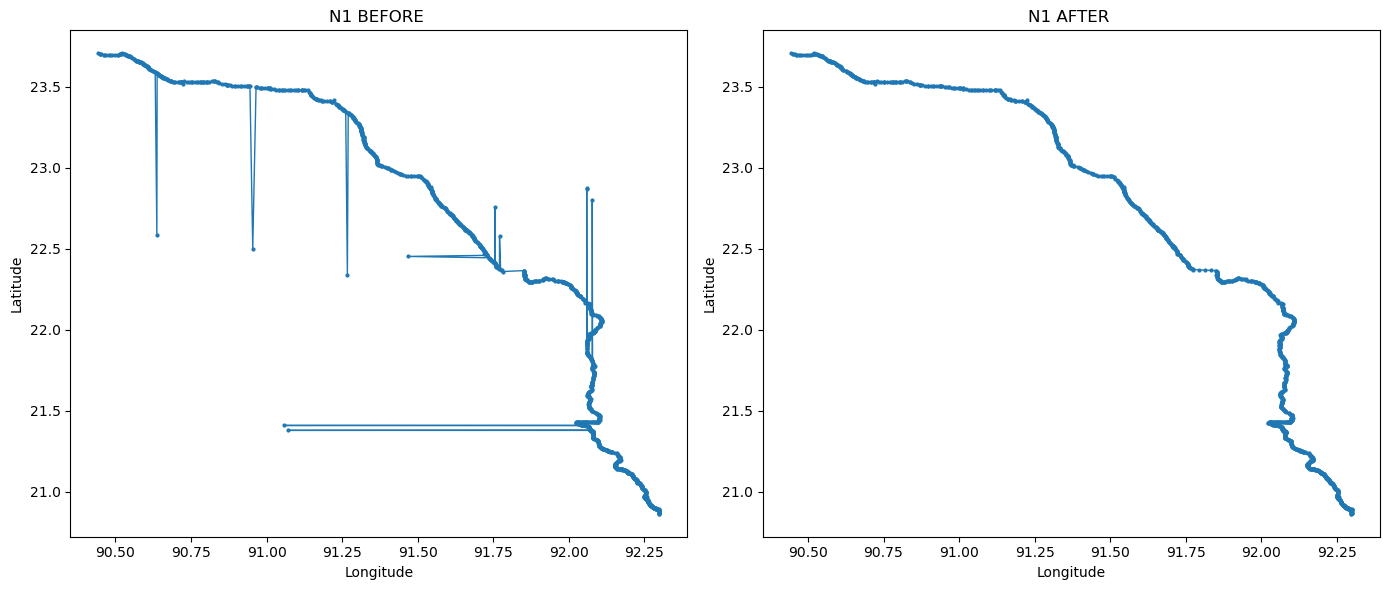

{'median_seg_before': 0.24966877898556183, 'thr_before': 3.7450316847834273, 'jumps_before': 23, 'max_seg_before': 112.16489375714244, 'median_seg_after': 0.25243396534927465, 'thr_after': 3.7865094802391197, 'jumps_after': 0, 'max_seg_after': 2.8560856083097277, 'actions_block': 9, 'actions_smart': 32, 'actions_end': 0, 'actions_total': 41}


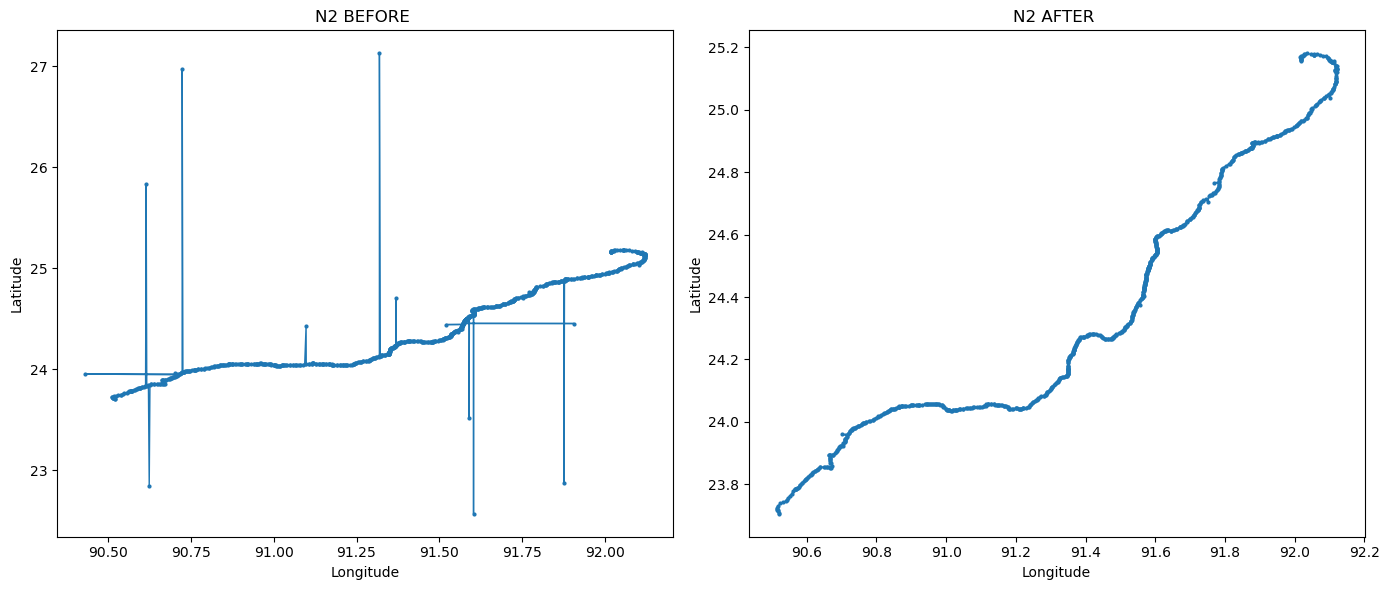

{'median_seg_before': 0.27002073788171577, 'thr_before': 4.050311068225737, 'jumps_before': 24, 'max_seg_before': 333.61567045487607, 'median_seg_after': 0.2650569699659913, 'thr_after': 3.9758545494898696, 'jumps_after': 0, 'max_seg_after': 2.2702737979702183, 'actions_block': 11, 'actions_smart': 24, 'actions_end': 0, 'actions_total': 35}


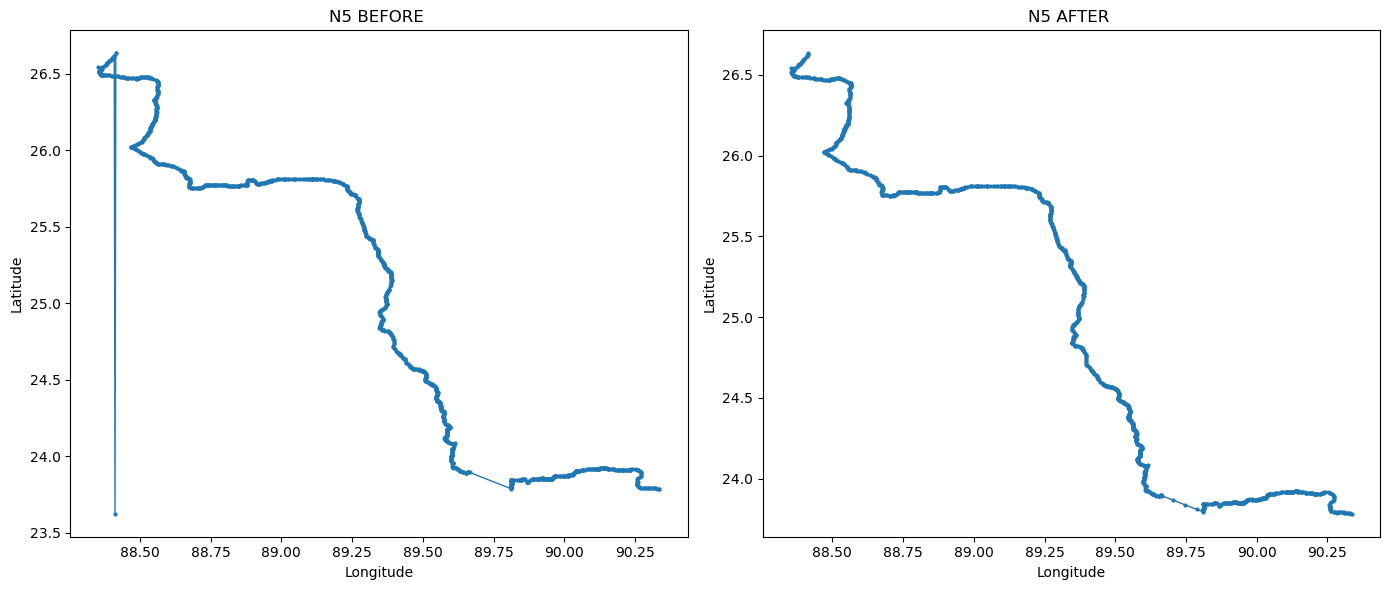

{'median_seg_before': 0.3324374720258134, 'thr_before': 4.986562080387201, 'jumps_before': 3, 'max_seg_before': 334.542391610489, 'median_seg_after': 0.3365250021009911, 'thr_after': 5.047875031514867, 'jumps_after': 3, 'max_seg_after': 5.4981509475008, 'actions_block': 1, 'actions_smart': 12, 'actions_end': 0, 'actions_total': 13}


In [24]:
plot_road_before_after(tidy, "N1", K=15)
plot_road_before_after(tidy, "N2", K=15)
plot_road_before_after(tidy, "N5", K=15) 

In [25]:
# fix all the roads
cleaned_tidy, actions_df, metrics_df = repair_all_roads(tidy, K=15, min_run_len=2, max_roads=None)
cleaned_tidy, actions_df, metrics_df = repair_all_roads(cleaned_tidy, K=15, min_run_len=2, max_roads=None)

print("Cleaned tidy shape:", cleaned_tidy.shape) #cleaned dataframe of road

Cleaned tidy shape: (51861, 4)


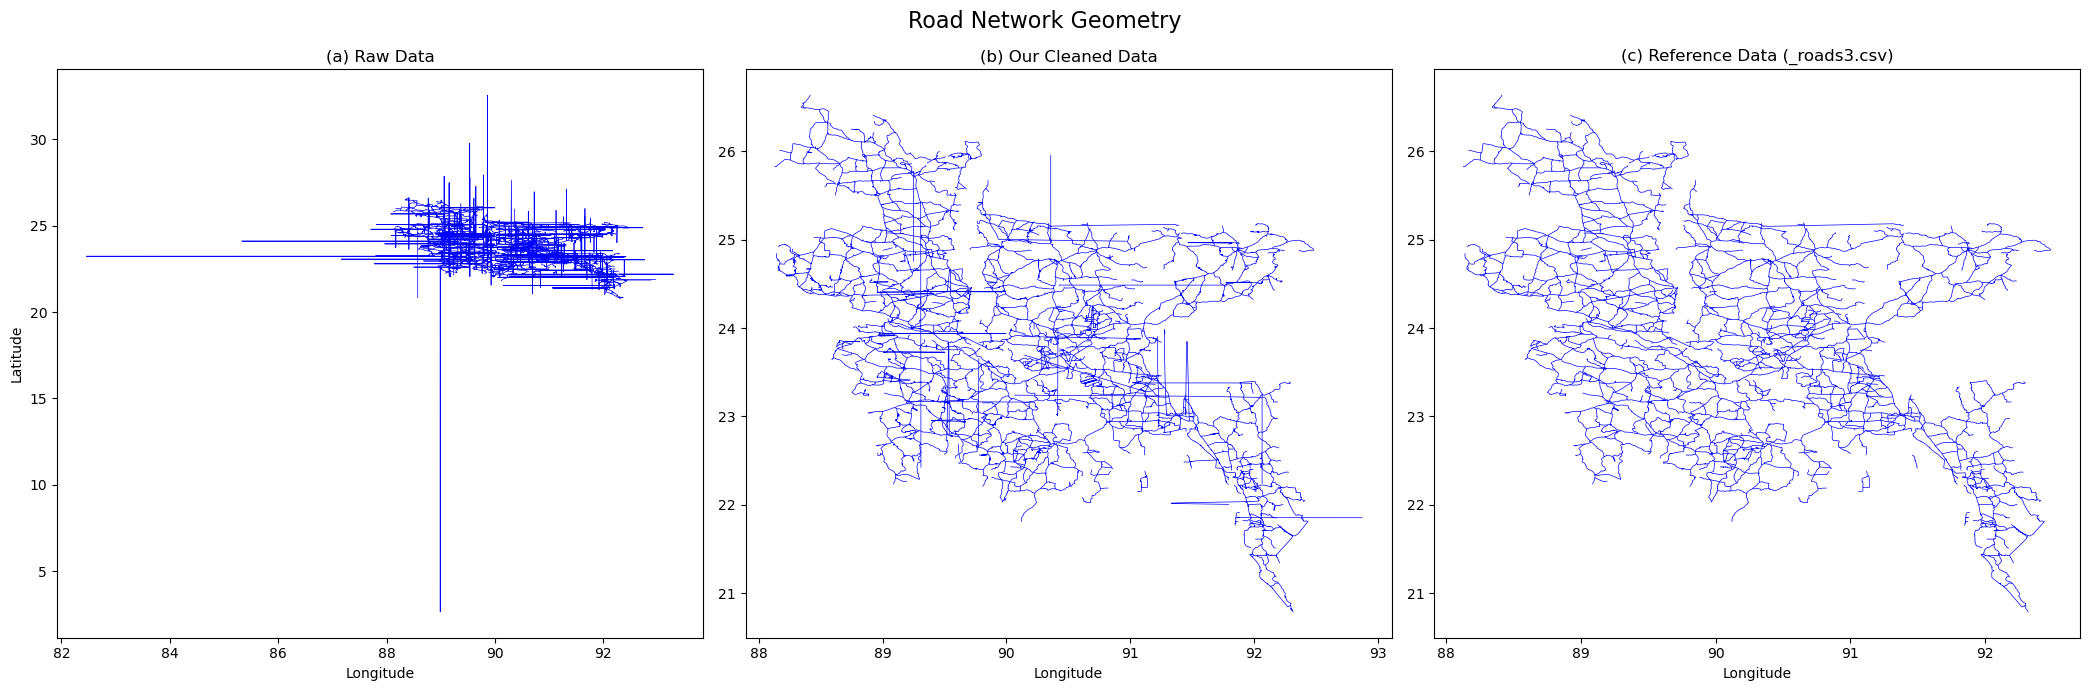

In [26]:
roads3 = pd.read_csv("../data/raw/_roads3.csv")

# Keep only geometry columns for comparison
roads3_tidy = roads3[["road", "lrp", "lat", "lon"]].copy()

plot_three_all_roads_lines(tidy, cleaned_tidy, roads3_tidy)

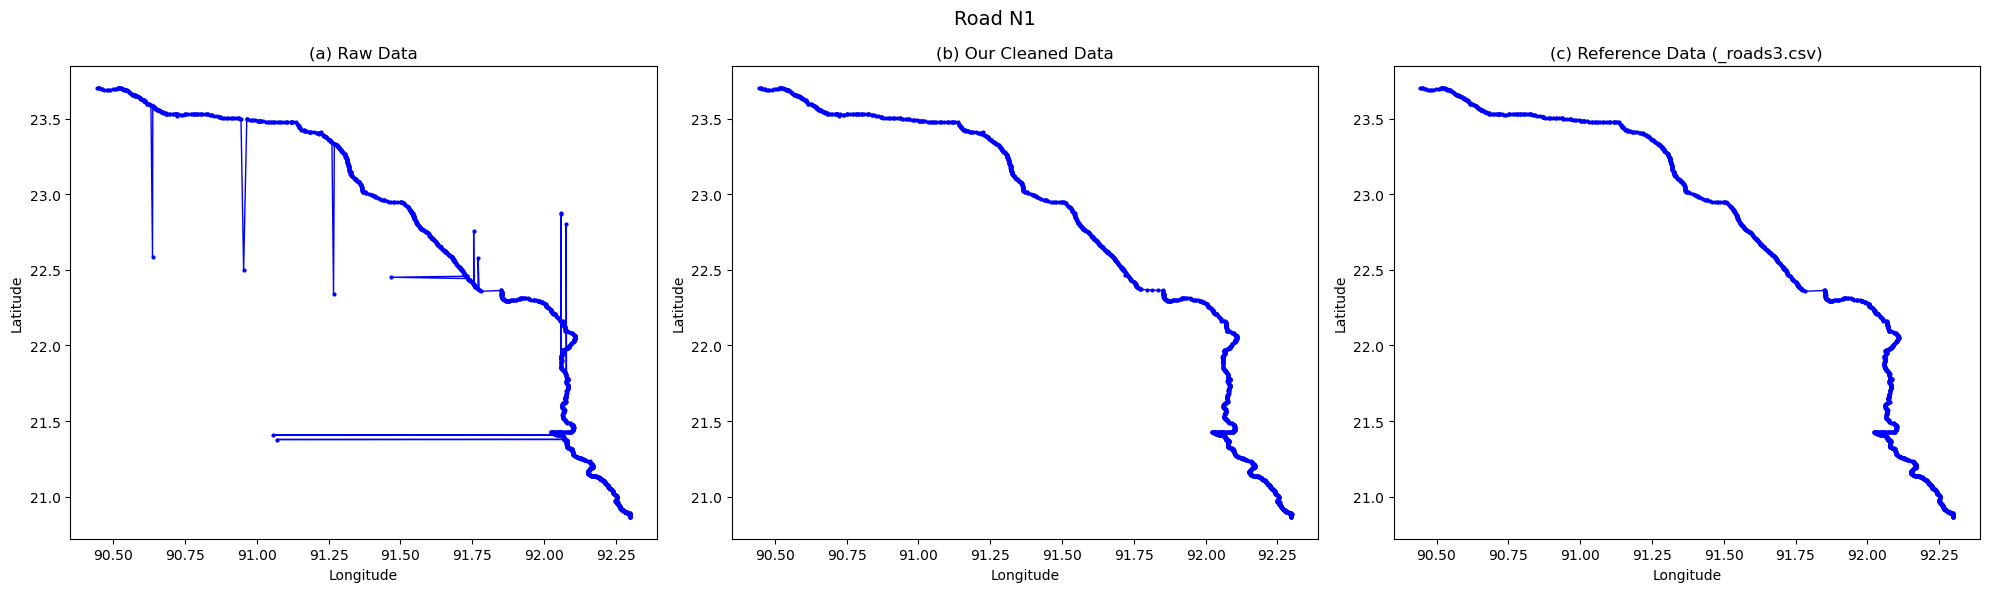

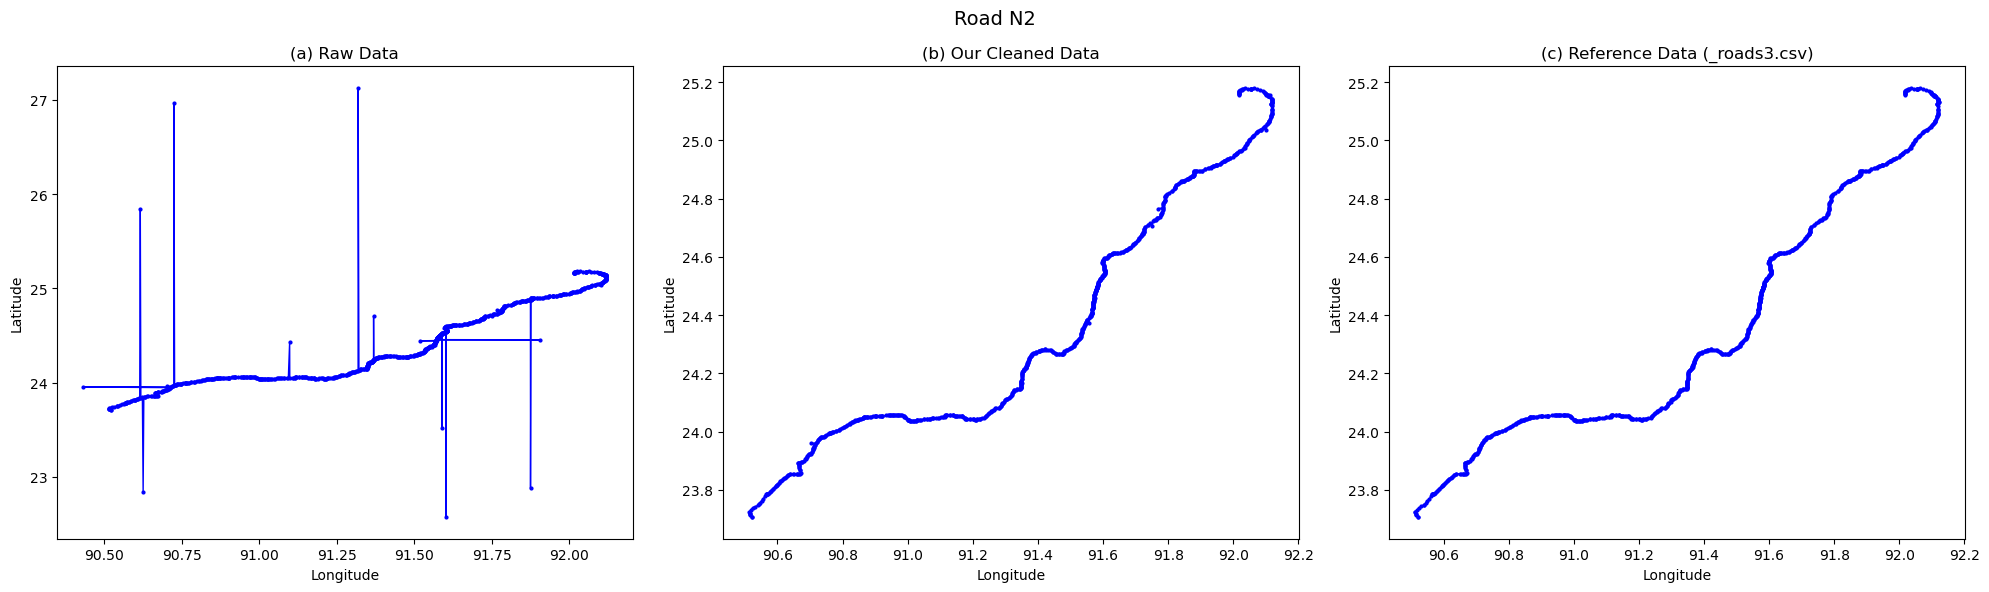

Road N113 not found in raw_tidy.


In [27]:
plot_road_raw_clean_ref(tidy, cleaned_tidy, "N1", ref_tidy=roads3_tidy, show_ref=True)
plot_road_raw_clean_ref(tidy, cleaned_tidy, "N2", ref_tidy=roads3_tidy, show_ref=True)
plot_road_raw_clean_ref(tidy, cleaned_tidy, "N113", ref_tidy=roads3_tidy, show_ref=True)  

## Save output file

In [28]:
RAW_PATH = Path("../data/raw/_roads.tsv")
OUT_PATH = Path("../data/processed/_roads.tsv")

# 1) Read original ONLY to steal its exact headers + number of columns
orig = pd.read_csv(RAW_PATH, sep="\t", low_memory=False)
orig_cols = list(orig.columns)
n_cols = len(orig_cols)

# 2) Keep cleaned_tidy order EXACTLY as-is
ct = cleaned_tidy.copy()

# Ensure consistent types 
ct["road"] = ct["road"].astype(str)
ct["lrp"]  = ct["lrp"].astype(str)

# 3) Stable road order: first appearance in cleaned_tidy
road_order = ct["road"].drop_duplicates().tolist()

rows = []
for road in road_order:
    g = ct[ct["road"] == road]  # preserves original row order in ct

    flat = []
    for _, r in g.iterrows():
        flat.extend([r["lrp"], r["lat"], r["lon"]])

    row = [road] + flat

    # pad / truncate to EXACT original width
    if len(row) < n_cols:
        row = row + [np.nan] * (n_cols - len(row))
    else:
        row = row[:n_cols]

    rows.append(row)

# 4) Build wide df and FORCE original headers (including Unnamed:* columns)
wide = pd.DataFrame(rows, columns=orig_cols)

# 5) Save as TSV
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
wide.to_csv(OUT_PATH, sep="\t", index=False, float_format="%.8f")

print(f"Saved (order-preserving) wide _roads.tsv to: {OUT_PATH}")
print("Shape:", wide.shape)

Saved (order-preserving) wide _roads.tsv to: ..\data\processed\_roads.tsv
Shape: (852, 4045)


---
# Bridges

---
## Check and remove selected duplicate values

In [29]:
excl=['structureNr']
cols=['road','chainage','condition','LRPName','lat','lon','name']

In [30]:
pd.set_option('display.max_columns', None)

In [31]:
df_bridges,log_dup2= check_duplicates(df_bridge, cols=cols, excl=excl)
print('Number of rows with duplicated values: ' + str(log_dup2.shape[0]))
print('Number of rows with total duplicated values: ' + str(log_dup2[(log_dup2['duplicate_reason']=="all column duplicate")].shape[0]))
print('Number of rows with duplicated values on selected column: ' + str(log_dup2[~(log_dup2['duplicate_reason']=="all column duplicate")].shape[0]))#duplicate on all column and only subset column, subject to remove

Number of rows with duplicated values: 18
Number of rows with total duplicated values: 14
Number of rows with duplicated values on selected column: 4


In [32]:
log_dup2[['road','LRPName']] #duplicated values, keep only the first occurence

,road,LRPName
0,R556,LRP015a
1,R556,LRP015a
2,Z5509,LRP026a
3,Z5509,LRP026a
4,N603,LRPSc
5,N603,LRPSc
6,Z8052,LRP009c
7,Z8052,LRP009c
8,N5,LRP388b
9,N5,LRP388b


---
## Check chainage monotony for bridges

In [33]:
df_roads = pd.read_csv("../data/raw/Roads_InfoAboutEachLRP.csv")

check_chainage_monotony(df_roads)

All roads in the dataset have chainage monotony


In [34]:
check_chainage_monotony(df_bridges)

# the output is only one road with broken montony R750, 
# but seems this doesn't have coordinates nor much data, likely to be road
# in conclusion, both datasets 

505 roads break chainage monotony
Roads that break monotony: Index(['N1', 'N102', 'N104', 'N105', 'N106', 'N107', 'N108', 'N110', 'N2',
       'N204',
       ...
       'Z8713', 'Z8717', 'Z8803', 'Z8806', 'Z8810', 'Z8905', 'Z8909', 'Z8910',
       'Z8913', 'Z8915'],
      dtype='object', name='road', length=505)


In [35]:
df_sorted_bridges = fix_chainage_monotony(df_bridges)
check_chainage_monotony(df_sorted_bridges)

1 roads break chainage monotony
Roads that break monotony: Index(['R750'], dtype='object', name='road')


In [36]:
df_sorted_bridges[(df_sorted_bridges['monotone']==False)]

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,monotone
7691,R750,NaN,RCC Girder Bridge,LRP006b,Daitala Bridge,41.5,A,118833,Jessore-Narail Road,NaN,NaN,NaN,NaN,Khulna,Jessore,Jessore,Jessore-2,NaN,NaN,bcs1,False


In [37]:
df_sorted_bridges[(df_sorted_bridges['road']=='R750') & (df_sorted_bridges['LRPName']=='LRP006b')]

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,monotone
7663,R750,6.135,RCC Girder Bridge,LRP006b,Daitala Bridge,41.6,C,104032,Jessore-Narail Road,6.135,7.28,1976.0,3.0,Khulna,Jessore,Jessore,Jessore-2,23.168056,89.279722,bcs1,True
7691,R750,NaN,RCC Girder Bridge,LRP006b,Daitala Bridge,41.5,A,118833,Jessore-Narail Road,NaN,NaN,NaN,NaN,Khulna,Jessore,Jessore,Jessore-2,NaN,NaN,bcs1,False


Chainage breaks because one entry in the road has a NaN value in the chainage column 

Since this row has the same LRP, name and length as another entry, we assume it refers to the same bridge

We drop the row with NaN value in chainage

In [38]:
df_sorted_bridges = df_sorted_bridges.drop(df_sorted_bridges[(df_sorted_bridges['chainage'].isna()) & (df_sorted_bridges["road"] == "R750")].index)
check_chainage_monotony(df_sorted_bridges)

All roads in the dataset have chainage monotony


In [39]:
df_sorted_bridges.to_excel("../data/processed/BMMS_cleaned_monotony.xlsx")

In [40]:
mask = check_bridges_invalid_roads(df_roads, df_bridges)
list_of_invalid_bridges = mask["road"].unique()
print("These bridges are on roads that don't exist on the roads dataset:\n", list_of_invalid_bridges)

These bridges are on roads that don't exist on the roads dataset:
 ['R505' 'R680' 'R750' 'R856' 'Z1006' 'Z1090' 'Z1211' 'Z1463' 'Z1503'
 'Z1632' 'Z2022' 'Z2033' 'Z2063' 'Z3614' 'Z5071' 'Z5073' 'Z5208' 'Z5458'
 'Z5459' 'Z5478' 'Z6801' 'Z6814' 'Z6815' 'Z1613' 'Z7048' 'Z7049' 'Z8711'
 'Z8948' 'Z1705']


In [41]:
df_bridges = drop_invalid_bridges(df_roads, df_bridges)
df_bridges.to_excel("../data/processed/BMMS_cleaned_bridges.xlsx")

---
## Check and fix inverted lattitude and longitude Issues

In [42]:
# Call the function to see the swapped bridges in data
a = detect_bridges_inverted_coordinates(df_sorted_bridges)
#a[(a['inverted_coords']==True)]

In [43]:
df_brigdes_2,log_swap=swap_lat_lon(a)

In [44]:
log_swap

,road,LRPName,old_lat,old_lon,new_lat,new_lon
0,R241,LRP026a,91.544194,24.773694,24.773694,91.544194
1,R241,LRP027a,91.542389,24.786833,24.786833,91.542389
2,R241,LRP028a,91.541778,24.790944,24.790944,91.541778
3,R241,LRP028c,91.542083,24.796694,24.796694,91.542083
4,R241,LRP029a,91.543889,24.805111,24.805111,91.543889
5,R241,LRP031a,91.538722,24.816556,24.816556,91.538722
6,R241,LRP032a,91.534361,24.823833,24.823833,91.534361
7,R241,LRP032b,91.530556,24.828056,24.828056,91.530556
8,R241,LRP033a,91.527917,24.830944,24.830944,91.527917
9,R241,LRP033b,91.524083,24.835222,24.835222,91.524083


In [45]:
print (str(log_swap.shape[0]) + " lrps swapped")

15 lrps swapped


---
## Check and fix applicable out of boundary issues

In [46]:
b=detect_bridges_out_coordinates(df_brigdes_2)

In [47]:
b[(b['far_out_coords']==True)].shape[0] #number of out of bound LRPs

24

In [48]:
df_brigdes_3,log_outofbound=fix_far_out_coords(b, tidy) #try to get the far out from the already corrected road dataframe
log_outofbound

,road,LRPName,old_lat,old_lon,new_lat,new_lon


8 out of bound values patched

In [49]:
df_brigdes_3[(df_brigdes_3["far_out_coords"]==True)].shape[0] #number of uncorrected data (including lat lon 0.0)

24

---
## Check and fix applicable NaN Values issue

In [50]:
#check NaN values on 'lat' and 'lon' columns, and drop them if they have duplicates with valid value
cleaned_df, removed_nan_rows = drop_redundant_nan_coords(df_brigdes_3)

cleaned_df.shape

(21308, 23)

In [51]:
print('Number of dropped rows: '+str(removed_nan_rows.shape[0]))

Number of dropped rows: 89


In [52]:
removed_nan_rows.head(10)[['road','LRPName','lat','lon']]

,road,LRPName,lat,lon
0,N208,LRP058b,NaN,NaN
1,R505,LRP007a,NaN,NaN
2,R680,LRP030a,NaN,NaN
3,R680,LRP034b,NaN,NaN
4,R680,LRP041b,NaN,NaN
5,R750,LRPSb,NaN,NaN
6,R750,LRP025a,NaN,NaN
7,R856,LRP009c,NaN,NaN
8,R856,LRP009e,NaN,NaN
9,R856,LRP010b,NaN,NaN


In [53]:
df_brigdes_4,log_NaN=fill_nan_coords(cleaned_df, cleaned_tidy) #try to get the nan from the already corrected road dataframe
log_NaN

,road,LRPName,new_lat,new_lon


no information on the remaining NaN that can be found in the other dataset, left as to not remove bridges information and allow for possible additional reference to be available

---
## Bridge Placement adjustment with interpolation

In [54]:
df_bridges_4=df_brigdes_4.rename(columns={'LRPName': 'lrp'})
df_bridges_4.head()

,road,km,type,lrp,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,monotone,inverted_coords,far_out_coords
0,N1,1.800,Box Culvert,LRP001a,.,11.30,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,1.800,19.50,2005.0,2.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.702889,90.450389,bcs1,True,False,False
1,N1,4.925,Box Culvert,LRP004b,.,6.60,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,4.925,35.40,2006.0,1.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.693611,90.478833,bcs1,True,False,False
2,N1,8.976,PC Girder Bridge,LRP008b,Kanch pur Bridge.,394.23,A,119889,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,NaN,NaN,NaN,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.704583,90.518833,road_precise,True,False,False
3,N1,8.976,PC Girder Bridge,LRP008b,KANCHPUR PC GIRDER BRIDGE,397.00,C,101102,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,14.65,1986.0,8.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.702083,90.515917,bcs1,True,False,False
4,N1,10.543,Box Culvert,LRP010a,KATCHPUR BOX CULVERT,8.00,B,101106,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.543,21.70,1987.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.702056,90.528194,bcs1,True,False,False


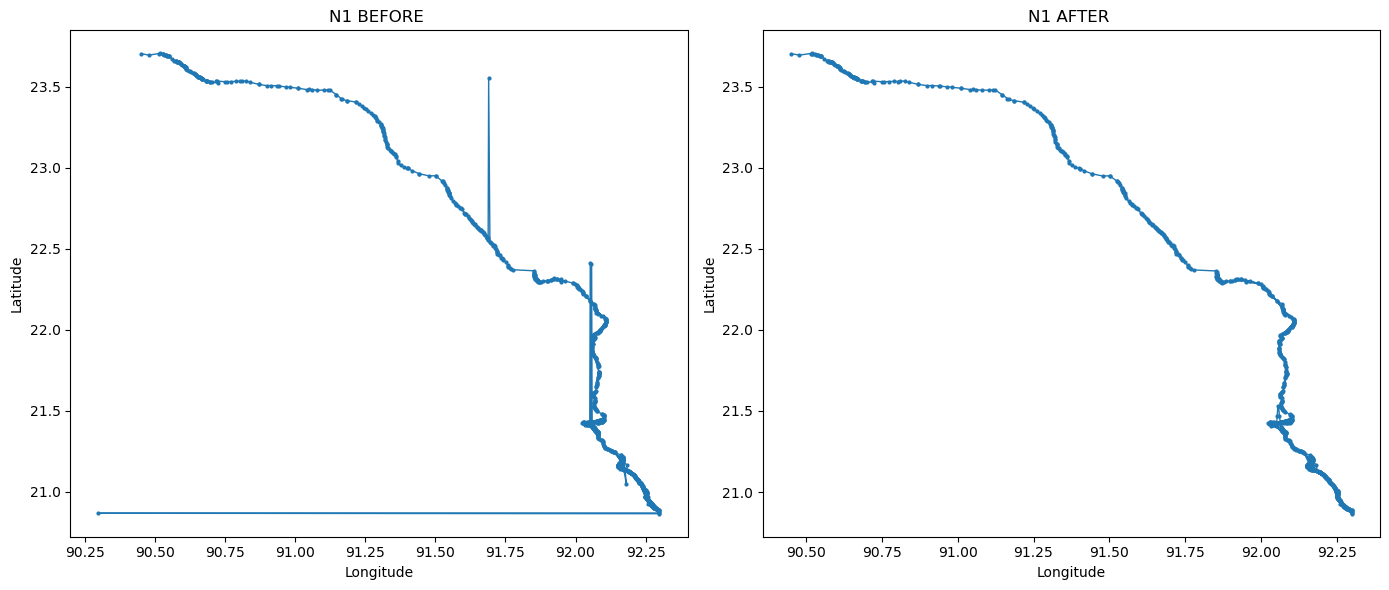

{'median_seg_before': 0.6585636184880912, 'thr_before': 9.878454277321367, 'jumps_before': 12, 'max_seg_before': 207.80079611309426, 'median_seg_after': 0.6457569364309788, 'thr_after': 9.68635404646468, 'jumps_after': 0, 'max_seg_after': 9.585754222687266, 'actions_block': 4, 'actions_smart': 18, 'actions_end': 0, 'actions_total': 22}


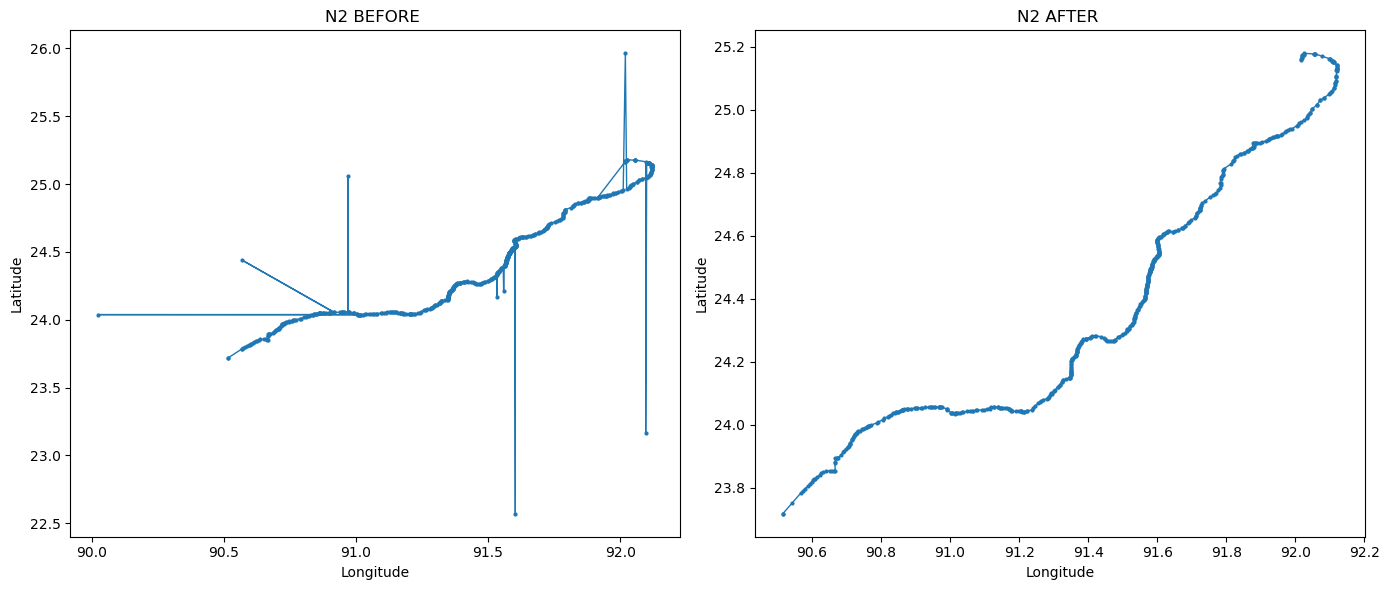

{'median_seg_before': 0.4218941893333078, 'thr_before': 6.328412839999617, 'jumps_before': 20, 'max_seg_before': 222.93672507651925, 'median_seg_after': 0.4081301442020295, 'thr_after': 6.121952163030442, 'jumps_after': 0, 'max_seg_after': 4.616584085058129, 'actions_block': 9, 'actions_smart': 18, 'actions_end': 1, 'actions_total': 28}


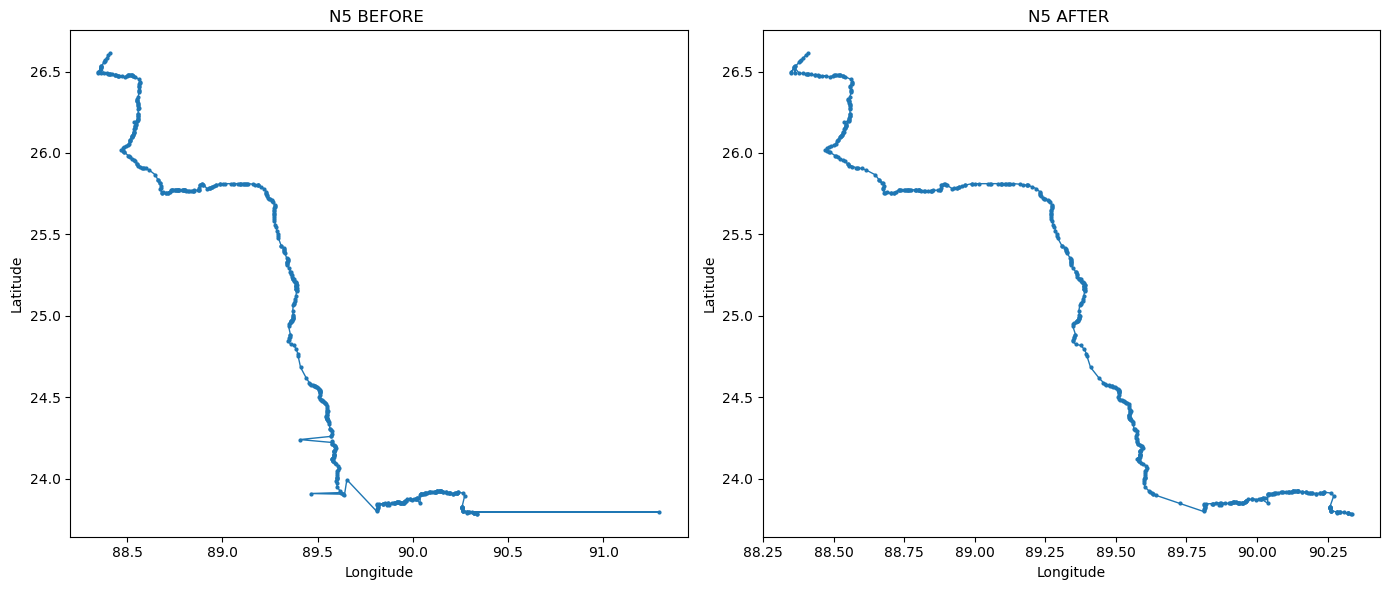

{'median_seg_before': 0.9376140207039829, 'thr_before': 14.064210310559744, 'jumps_before': 7, 'max_seg_before': 101.74312214242858, 'median_seg_after': 0.9328671445728317, 'thr_after': 13.993007168592476, 'jumps_after': 0, 'max_seg_after': 10.273134726484786, 'actions_block': 2, 'actions_smart': 7, 'actions_end': 0, 'actions_total': 9}


In [55]:
plot_road_before_after(df_bridges_4, "N1", K=15)
plot_road_before_after(df_bridges_4, "N2", K=15)
plot_road_before_after(df_bridges_4, "N5", K=15)

In [56]:
cleaned_tidy, actions_df, metrics_df = repair_all_bridges(df_bridges_4, K=15, min_run_len=2, max_roads=None)
print("Cleaned tidy shape:", cleaned_tidy.shape)

Cleaned tidy shape: (21308, 23)


---
## Bridge data that still left unfixed

In [57]:
d=detect_bridges_out_coordinates(cleaned_tidy) #recheck out of boundary

In [58]:
problem_rows = d[
    d[["lat", "lon"]].isna().any(axis=1) |
    d["far_out_coords"]
]
print('Number of rows that are left unfixed:' + str(problem_rows.shape[0])) 

Number of rows that are left unfixed:22


In [59]:
problem_rows.head() #rows where data is NaN or still out of bounds after look up and interpolation

,road,km,type,lrp,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,monotone,inverted_coords,far_out_coords
5327,R203,80.287,RCC Girder Bridge,LRP082b,Godir Bridge,8.66,C,119894,Bhulta-Araihazar-Bancharampur-Nabinagar-Shibpu...,80.287,NaN,NaN,NaN,Comilla,Comilla,Brahmanbaria,Bancharampur,NaN,NaN,error,True,False,False
11906,Z1811,147.040,Baily with Steel Deck,LRP149a,Tulatoli Bridge,24.15,A,121607,Bandarban-Chimbuk-Thanchi-Alikadam-Baisari-Nai...,147.040,NaN,NaN,NaN,Chittagong,Rangamati,Bandarban,Bandarban-1,0.0,0.0,road_interpolate,True,False,True
11907,Z1811,147.506,RCC Girder Bridge,LRP149d,Naikhongchari Bazar Bridge.,12.50,A,121608,Bandarban-Chimbuk-Thanchi-Alikadam-Baisari-Nai...,147.506,NaN,NaN,NaN,Chittagong,Rangamati,Bandarban,Bandarban-1,0.0,0.0,road_interpolate,True,False,True
11913,Z1811,148.667,Baily with Timber Deck,LRP150b,Uttor Bisamara Bridge,15.60,C,121612,Bandarban-Chimbuk-Thanchi-Alikadam-Baisari-Nai...,148.667,NaN,NaN,NaN,Chittagong,Rangamati,Bandarban,Bandarban-1,0.0,0.0,road_interpolate,True,False,True
11914,Z1811,149.145,RCC Girder Bridge,LRP151a,South Bisamara Bridge,6.80,A,121620,Bandarban-Chimbuk-Thanchi-Alikadam-Baisari-Nai...,149.145,NaN,NaN,NaN,Chittagong,Rangamati,Bandarban,Bandarban-1,0.0,0.0,road_interpolate,True,False,True


---
## Cleaned bridges dataset with problem rows removed in plot

In [60]:
valid_df = cleaned_tidy.drop(index=problem_rows.index)

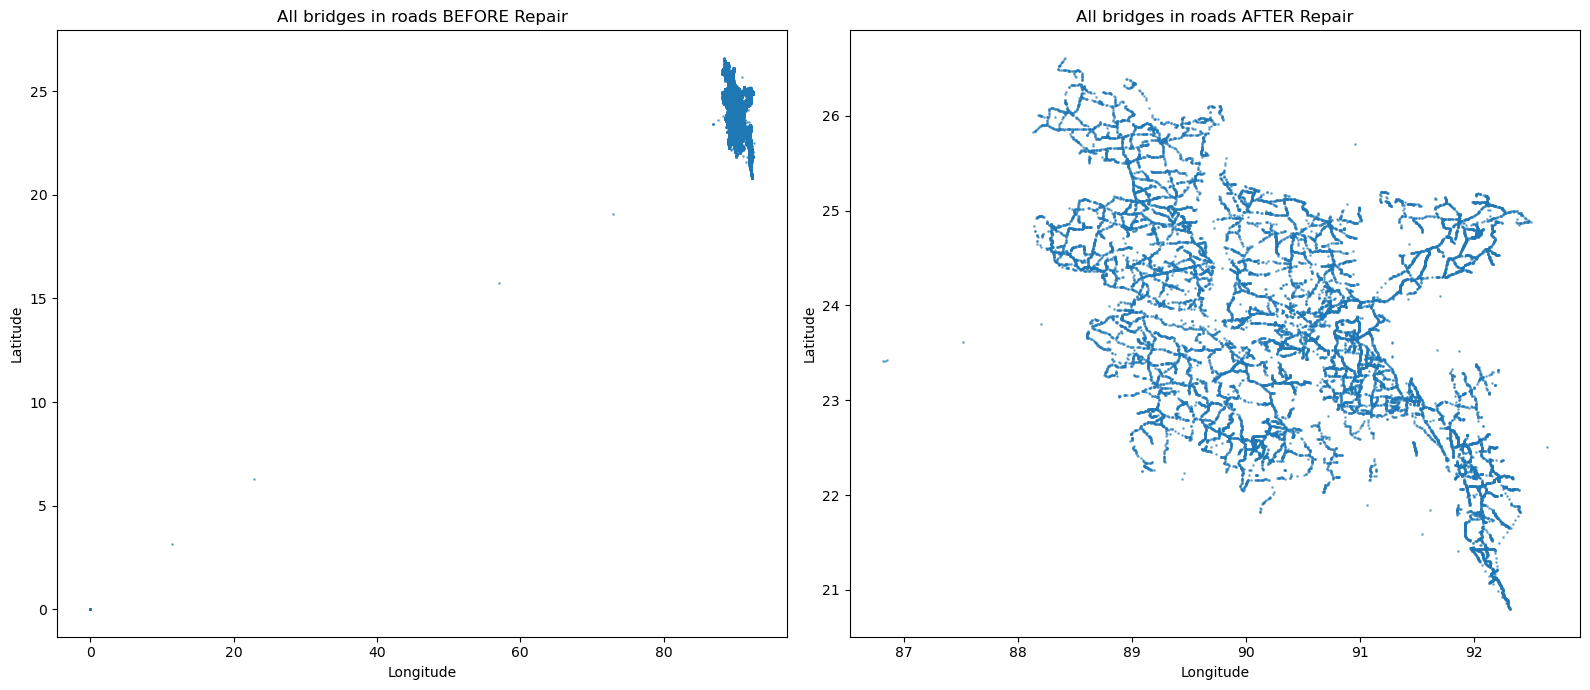

In [61]:
plot_all_bridge_before_after(cleaned_tidy,valid_df)

---
## Write output to excel

In [62]:
cleaned_tidy.columns

Index(['road', 'km', 'type', 'lrp', 'name', 'length', 'condition',
       'structureNr', 'roadName', 'chainage', 'width', 'constructionYear',
       'spans', 'zone', 'circle', 'division', 'sub-division', 'lat', 'lon',
       'EstimatedLoc', 'monotone', 'inverted_coords', 'far_out_coords'],
      dtype='object')

In [63]:
#drop unused column and rename previously changed column
output_df = (
    cleaned_tidy
    .drop(columns=["monotone", "inverted_coords", "far_out_coords"])
    .rename(columns={"lrp": "LRPName"})
)

In [64]:
with pd.ExcelWriter("../data/processed/BMMS_overview.xlsx", engine="openpyxl") as writer:
    output_df.to_excel(writer, sheet_name="BMMS_overview", index=False)

---
#  EXTRAS: Checking Manual after inspecting the java visualisation

In [65]:
# read processed BMMS overview
df_bmms = pd.read_excel("../data/processed/BMMS_overview.xlsx")
df_RoadsInfo = pd.read_csv("../data/raw/Roads_InfoAboutEachLRP.csv")

After checking the Java output, there are some Bridge LRPs that can still be manually fixed. Here is the list and the problems with each.

- All LRP of Z1071 in the bridges data, its coordinate should be the same as in the road data

- R164 LRPSa: typo longitude from 92.640028 should be 92.140028
- Z1076 LRP001a: typo latitude from 21.410806 should be 21.910806
- Z1220 LRP002b: typo latitude from 25.70527778 should be 23.70527778
- Z1619 LRPSa: typo latitude from 23.52455556 should be 22.52455556
- Z1220 LRP002b: typo latitude from 25.70527778 should be 23.70527778

In [66]:
# Update all Z1071 coordinates in df_bmms from df_RoadsInfo (match on road + LRP)
ref_z1071 = (
    df_RoadsInfo.loc[df_RoadsInfo["road"] == "Z1071", ["road", "lrp", "lat", "lon"]]
    .dropna(subset=["lat", "lon"])
    .drop_duplicates(subset=["road", "lrp"], keep="first")
)

bmms_z1071 = df_bmms.loc[df_bmms["road"] == "Z1071"].copy()
bmms_z1071["_idx"] = bmms_z1071.index

merged_z1071 = bmms_z1071.merge(
    ref_z1071,
    left_on=["road", "LRPName"],
    right_on=["road", "lrp"],
    how="left",
    suffixes=("", "_ref")
)

matched = merged_z1071["lat_ref"].notna() & merged_z1071["lon_ref"].notna()
idx_to_update = merged_z1071.loc[matched, "_idx"]

# optional log of changes
z1071_update_log = pd.DataFrame({
    "idx": idx_to_update.values,
    "road": merged_z1071.loc[matched, "road"].values,
    "LRPName": merged_z1071.loc[matched, "LRPName"].values,
    "old_lat": merged_z1071.loc[matched, "lat"].values,
    "old_lon": merged_z1071.loc[matched, "lon"].values,
    "new_lat": merged_z1071.loc[matched, "lat_ref"].values,
    "new_lon": merged_z1071.loc[matched, "lon_ref"].values,
})

df_bmms.loc[idx_to_update, ["lat", "lon"]] = merged_z1071.loc[matched, ["lat_ref", "lon_ref"]].to_numpy()

print(f"Z1071 rows in df_bmms: {len(bmms_z1071)}")
print(f"Updated from df_RoadsInfo: {matched.sum()}")
print(f"Unmatched LRPs: {len(bmms_z1071) - matched.sum()}")

Z1071 rows in df_bmms: 3
Updated from df_RoadsInfo: 3
Unmatched LRPs: 0


In [67]:
# check road Z1071 in df_bmms after update
df_bmms[df_bmms["road"] == "Z1071"][["LRPName", "lat", "lon"]]

,LRPName,lat,lon
9792,LRPSa,22.297944,91.896194
9793,LRP002a,22.290583,91.907972
9794,LRP003a,22.285250,91.915861


In [68]:
# Manual typo fixes for df_bmms (road + LRP-specific)
manual_fixes = [
    {"road": "R164",  "LRPName": "LRPSa",   "col": "lon", "old": 92.640028,   "new": 92.140028},
    {"road": "Z1076", "LRPName": "LRP001a", "col": "lat", "old": 21.410806,   "new": 21.910806},
    {"road": "Z1220", "LRPName": "LRP002b", "col": "lat", "old": 25.70527778, "new": 23.70527778},
    {"road": "Z1619", "LRPName": "LRPSa",   "col": "lat", "old": 23.52455556, "new": 22.52455556},
]

fix_logs = []

for f in manual_fixes:
    base_mask = (df_bmms["road"] == f["road"]) & (df_bmms["LRPName"] == f["LRPName"])
    # Prefer exact typo match; fallback to road+LRP if exact old value is not found
    exact_mask = base_mask & np.isclose(df_bmms[f["col"]], f["old"], atol=1e-9, equal_nan=False)
    mask = exact_mask if exact_mask.any() else base_mask

    if mask.any():
        tmp_log = df_bmms.loc[mask, ["road", "LRPName", f["col"]]].copy()
        tmp_log = tmp_log.rename(columns={f["col"]: "old_value"})
        tmp_log["column"] = f["col"]
        tmp_log["new_value"] = f["new"]
        fix_logs.append(tmp_log)

        df_bmms.loc[mask, f["col"]] = f["new"]

manual_fix_log = pd.concat(fix_logs, ignore_index=True) if fix_logs else pd.DataFrame(
    columns=["road", "LRPName", "old_value", "column", "new_value"]
)

print(f"Rows updated: {len(manual_fix_log)}")
manual_fix_log

Rows updated: 4


,road,LRPName,old_value,column,new_value
0,R164,LRPSa,92.640028,lon,92.140028
1,Z1076,LRP001a,21.410806,lat,21.910806
2,Z1220,LRP002b,25.705278,lat,23.705278
3,Z1619,LRPSa,23.524556,lat,22.524556


In [69]:
# check the manually fixed rows
mask = (
    ((df_bmms["road"] == "R164") & (df_bmms["LRPName"] == "LRPSa")) |
    ((df_bmms["road"] == "Z1076") & (df_bmms["LRPName"] == "LRP001a")) |
    ((df_bmms["road"] == "Z1220") & (df_bmms["LRPName"] == "LRP002b")) |
    ((df_bmms["road"] == "Z1619") & (df_bmms["LRPName"] == "LRPSa"))
)

df_bmms[mask]

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
5041,R164,0.116,Box Culvert,LRPSa,BARAICHARI BOX CULVERT,6.00,A,106763,Baraichhari-Kaptai Road,0.116,8.50,1976.0,1.0,Chittagong,Chittagong,Chittagong,Chittagong,22.503194,92.140028,bcs1
9795,Z1076,1.870,Box Culvert,LRP001a,.,3.50,A,117740,Kutubdia-Azam Sarak,1.870,9.06,2000.0,1.0,Chittagong,Chittagong,Cox's Bazar,Chakoria,21.910806,91.863972,bcs1
10470,Z1220,2.300,Box Culvert,LRP002b,.,6.90,A,116903,Rajachapitala-Ramchandrapur-Patchkitta Road,2.300,7.40,2006.0,1.0,Comilla,Comilla,Comilla,Gouripur,23.705278,90.959167,bcs1
11647,Z1619,0.409,RCC Bridge,LRPSa,Kalachin Chaduri Bridge,46.40,A,102930,Raozan (Gohira)-Fatikchhari Road,0.409,3.50,1982.0,3.0,Chittagong,Chittagong,Chittagong,Fatikchari,22.524556,91.867000,bcs1
11648,Z1619,0.409,Truss with Steel Deck,LRPSa,Saltar Bridge,49.57,C,121324,Raozan (Gohira)-Fatikchhari Road,0.409,NaN,NaN,NaN,Chittagong,Chittagong,Chittagong,Fatikchari,22.525166,91.866417,road_precise


# EXTRAS: Check Bridges LRPs using SHP of Bangladesh (Polygon)

The code below will take a lot of time to run. We took +35 minutes to run because the code performs many expensive geometric operations one row at a time on a complex polygon, and does so twice per record.

We have created BMMS_with_SHP.xlsx, which is the output of the code below, so when the TA checks it, they do not need to run this code for as long.

LRPs that out of the bangladesh polygon including the Nan in lon or lat, and swapped coordinates

The printed counts (231 total outside-boundary rows) are internally consistent:
- 111 (NaN/zero)
- 15 (swapped)
- 105 (valid coordinates but still outside boundary)
- 111 + 15 + 105 = 231